# Generate Water Body Polygons

**What does this notebook do?** This notebook uses output `NetCDF` files of WOFS summaries from `datacube-stats` to generate polygons of water bodies in the landscape. This code follows the following workflow:
* Generate a list of netCDF files within a specified folder location
* Opens each netCDF file and:
    * Keep only pixels identified as wet at least 10% of the time
    * Convert the raster data into polygons
    * Filter the polygons based on size and proximity to identified major rivers
    * Remove any named water bodies - e.g. lakes
* Append the final polygon set to a shapefile

**Required inputs:** 
This code requires that you have run `datacube-stats` to produce WOFS summaries as netCDF files. This code takes in the folder location to generate a list of netCDF files to process.

**Code history**
This notebook is an updated version of `FindLotsOfDamsUsingWOFLsInaLoop.ipynb`. This copy was created to maintain the prototype workflow, while updating the operational workflow for water body polygon production.

**Date:** March 2019

**Author:** Claire Krause

In [1]:
%pylab notebook

import rasterio.features
from shapely.geometry import Polygon, shape, mapping
from shapely.ops import unary_union
import geopandas as gp
import fiona
from fiona.crs import from_epsg
import xarray as xr
import pandas as pd
import glob
import os.path

Populating the interactive namespace from numpy and matplotlib


## Set up the functions for this script

In [2]:
def GenerateListofAlbersTiles(TileFolder = 'TileFolder'):
    '''
    Generate a list of Albers tiles to loop through for the water body analysis. This 
    function assumes that the list of tiles will be generated from a custom 
    datacube-stats run, and the file names will have the format
    
    */wofs_summary_8_-37_{date}.nc
    
    The tile number is expected in the 2nd and 3rd last positions when the string has been
    broken using `_`. If this is not the case, then this code will not work, and will throw an error. 
    
    Parameters
    ----------
    
    TileFolder : str
        This is the path to the folder of netCDF files for analysis. If this is not provided, or an
        incorrect path name is provided, the code will exit with an error.
    
    Returns
    -------
    CustomRegionAlbersTiles: list
        List of Albers tiles across the analysis region. 
        E.g. ['8_-32', '9_-32', '10_-32', '8_-33', '9_-33']
    
    '''  
    if os.path.exists(TileFolder) == False:
        print('** ERROR ** \n'
            'You need to specify a folder of files for running a custom region')
        return
    
    # Grab a list of all of the netCDF files in the custom folder
    TileFiles = glob.glob(f'{TileFolder}*.nc')

    CustomRegionAlbersTiles = set()
    for filePath in TileFiles:
        AlbersTiles = filePath.split('_')
        
        # Test that the albers tile numbers are actually where we expect them to be in the file name
        try: 
            int(AlbersTiles[-3])
        except ValueError:
            print('** ERROR ** \n'
                'The netCDF files are expected to have the file format "*/wofs_summary_8_-37_{date}.nc",\n'
                'with the Albers tile numbers in the 2nd and 3rd last positions when separated on `_`. \n'
                'Please fix the file names, or alter the `GenerateListofAlbersTiles` function.')
            return
        try: 
            int(AlbersTiles[-2])
        except ValueError:
            print('** ERROR ** \n'
                'The netCDF files are expected to have the file format "*/wofs_summary_8_-37_{date}.nc",\n'
                'with the Albers tile numbers in the 2nd and 3rd last positions when separated on `_`. \n'
                'Please fix the file names, or alter the `GenerateListofAlbersTiles` function.')
            return

        # Now that we're happy that the file is reading the correct Albers tiles
        ThisTile = f'{AlbersTiles[-3]}_{AlbersTiles[-2]}'
        CustomRegionAlbersTiles.add(ThisTile)
    CustomRegionAlbersTiles = list(CustomRegionAlbersTiles)
    return CustomRegionAlbersTiles

def GenerateListofTileDatasets(ListofAlbersTiles, Year, TileFolder = 'TileFolder'):
    '''
    Generate a list of Albers tiles datasets to loop through for the water body analysis. 
    
    Parameters
    ----------
    
    CustomRegionAlbersTiles: list
        List of albers tiles to loop through
        E.g. ['8_-32', '9_-32', '10_-32', '8_-33', '9_-33']
    Year: int
        Year for the analysis. This will correspond to the netCDF files for analysis.
    TileFolder : str
        This is the path to the folder of netCDF files for analysis. If this is not provided, or an
        incorrect path name is provided, the code will exit with an error.
    
    Returns
    -------
    Alltilespaths: list
        List of file paths to files to be analysed.
    
    '''  
    
    if os.path.exists(TileFolder) == False:
        print('** ERROR ** \n'
            'You need to specify a folder of files for running a custom region')
        return

    Alltilespaths = []
    
    for tile in ListofAlbersTiles:
        Tiles = glob.glob(f'{TileFolder}*_{tile}_{Year}0101.nc')
        Alltilespaths.append(Tiles[0]) # Assumes only one file will be returned
 
    return Alltilespaths

def FilterRivers(gpdData, gpdRivers):
    '''
    Filter out polygons that intersect with a river line segment. 
    
    Parameters
    ----------
    
    gpdData: geopandas dataframe
        Polygon data that you wish to filter
    gpdRivers: geopandas dataframe
        Dataset you are using as a filter
    
    Returns
    -------
    gpdDataRiverFiltered: geopandas dataframe
        Filtered polygon set, with polygons that intersect with gpdRivers removed.
    
    '''    
    
    # Check that the coordinate reference systems of both dataframes are the same
    try:
        assert gpdData.crs == gpdRivers.crs
    except AssertionError:
        print('Make sure the the coordinate reference systems of the two provided dataframes are the same')
    
    Intersections = gp.sjoin(gpdRivers, gpdData, how="inner", op='intersects')
    
    # Find the index of all the polygons that intersect with a river
    IntersectIndex = sorted(list(set(Intersections['index_right'])))
    
    # Grab only the polygons NOT in the IntersectIndex
    # i.e. that don't intersect with a river
    gpdDataRiverFiltered = gpdData.loc[~gpdData.index.isin(IntersectIndex)]
    
    return gpdDataRiverFiltered

## Set up all the parameters for the script

### How wet does a pixel need to be to be included?
The value set here will be the minimum amount of time (as a decimal between 0 and 1) that you want water to be detected before it is included in the analysis. 

E.g. If this was set to 0.10, any pixels that are wet *at least* 10% of the time will be included. If you are looking for persistant water bodies, you will want to set this threshold higher. If you don't want to use this filter, set this value to 0.

In [3]:
AtLeastThisWet = 0.10

### How big/small should the polygons be?
This filtering step can remove very small and/or very large polygons. The size listed here is in m2. A single pixel in Landsat data is 25 m X 25 m = 625 m2. 

**MinSize**

E.g. A minimum size of 6250 means that polygons need to be at least 10 pixels to be included. If you don't want to use this filter, set this value to 0.

**MaxSize**

E.g. A maximum size of 1 000 000 means that you only want to consider polygons less than 1 km2. If you don't want to use this filter, set this number to something stupidly large.

In [4]:
MinSize = 3120 # 5 pixels
MaxSize = 10000000000000000000000000000000000000000000000000000000000000000000000000000 # No upper limit

### Do you want to filter out polygons that intersect with major rivers?

We use the [Bureau of Meteorology's Geofabric v 2.1.1 (Suface Hydrology Network)](ftp://ftp.bom.gov.au/anon/home/geofabric/) to filter out polygons that intersect with major rivers. We use the `SH_Network AHGFNetworkStream any` layer within the `SH_Network_GDB_V2_1_1.zip` geodatabase, and filter the dataset to only keep rivers tagged as `major`. It is this filtered dataset we use here.

Note that we reproject this dataset to `epsg 3577`, Australian Albers coordinate reference system. If this is not correct for your analysis, you can change this in the cell below.

If you don't want to filter out polygons that intersect with rivers, set this parameter to `False`.

In [5]:
FilterOutRivers = True

# Where is this file located?
MajorRiversDataset = '/g/data/r78/cek156/ShapeFiles/Geofabric_v2_1_1/SH_Network_GDB_V2_1_1_Major_Filtered.shp'

In [6]:
# Read in the major rivers dataset (if you are using it)
if FilterOutRivers == True:
    MajorRivers = gp.GeoDataFrame.from_file(MajorRiversDataset) 
    MajorRivers = MajorRivers.to_crs({'init':'epsg:3577'})

### Is this analysis for all of Australia, or just a subset?

If `CustomRegion = False`, the code will conduct the analysis for all of Australia. (NOTE the code isn't actually set up for this option as yet...)

If `CustomRegion = True`, it means you would like to analyse only some part of Australia, and you will need to provide a folder of data to be analysed in `TileFolder` below.  

If you would like to automatically generate a list of tiles using the outputs of an analysis (e.g. we have previously run a custom `datacube-stats` analysis using this region, and so we can generate a list of tiles that we know covers this area using the outputs of this analysis), set `AutoGenerateTileList = True` and update the location of the output file directory.

If you would like to manually feed in a list of albers tiles, set `AutoGenerateTileList = False`, and feed in a list of tiles in the format:

```
SubRegionAlbersTiles = ['8_-32', '9_-32', '10_-32', '8_-33', '9_-33']
                        ```

In [7]:
CustomRegion = True
AutoGenerateTileList = False #True
TileFolder = '/g/data/r78/cek156/datacube_stats/WOFSDams2000to2018/'

### Where are the files on which to perform the analysis?

In [8]:
if CustomRegion == True:
    ListofAlbersTiles = GenerateListofAlbersTiles(TileFolder)
elif CustomRegion == False:
    TileFolder = '/g/data/fk4/datacube/002/WOfS/WOfS_Filt_Stats_25_2_1/netcdf/'

In [23]:
if AutoGenerateTileList == False:
    ListofAlbersTiles =  ['17_-39']#, '8_-32']
#     ['8_-32', '9_-32', '10_-32', '8_-33', '9_-33','10_-33','11_-33',
#                             '12_-33','13_-33','14_-33', '15_-33','16_-33','17_-33','18_-33',
#                             '19_-33','20_-33','8_-34','9_-34','10_-34','11_-34','12_-34',
#                             '13_-34','14_-34','15_-34','16_-34','17_-34','18_-34','19_-34',
#                             '20_-34','8_-35','9_-35','10_-35','11_-35','12_-35','13_-35',
#                             '14_-35','15_-35','16_-35','17_-35','18_-35','19_-35','20_-35',
#                             '8_-36','9_-36','10_-36','11_-36','12_-36','13_-36','14_-36',
#                             '15_-36','16_-36','17_-36','18_-36','19_-36','8_-37','9_-37',
#                             '10_-37','11_-37','12_-37','13_-37','14_-37','15_-37','16_-37',
#                             '17_-37','18_-37','19_-37','8_-38','9_-38','10_-38','11_-38',
#                             '12_-38','13_-38','14_-38','15_-38','16_-38','17_-38','18_-38',
#                             '9_-39','10_-39','11_-39','12_-39','13_-39','14_-39','15_-39',
#                             '16_-39','17_-39','10_-40','11_-40','12_-40','13_-40','14_-40',
#                             '15_-40','16_-40','17_-40','11_-41','12_-41','13_-41','14_-41',
#                             '15_-41','16_-41','14_-42','15_-42','16_-42','15_-43']

## Set up a land/sea mask

Use the GEODATA COAST 100K 2004 dataset (https://data.gov.au/dataset/geodata-coast-100k-2004) as a coarse approximation of the mean high water coastline to remove ocean from water layers

<IPython.core.display.Javascript object>


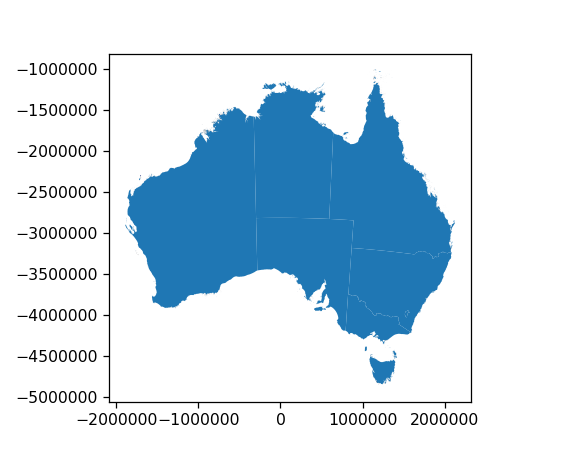

In [10]:
coastline_gp = gp.read_file('/g/data/r78/rt1527/datasets/Coastlines/australia/cstauscd_r.shp')
coastline_gp = coastline_gp.to_crs({'init': 'epsg:3577'})
coastline_gp = coastline_gp[(coastline_gp.FEAT_CODE == 'island') | (coastline_gp.FEAT_CODE == 'mainland')]
coastline_gp.plot(figsize=(5, 4))

### Estuaries need to be handled separately

An estuary data layer was generated from the [OzCoasts Geomerphic habitat datasets](http://www.ozcoasts.gov.au/search_data/datasets.jsp). Each of the state datasets were downloaded, and only `channel` and `Central Basin` features were retained. These correspond to the locations of open water (including large river channels) within estuary systems.

<IPython.core.display.Javascript object>


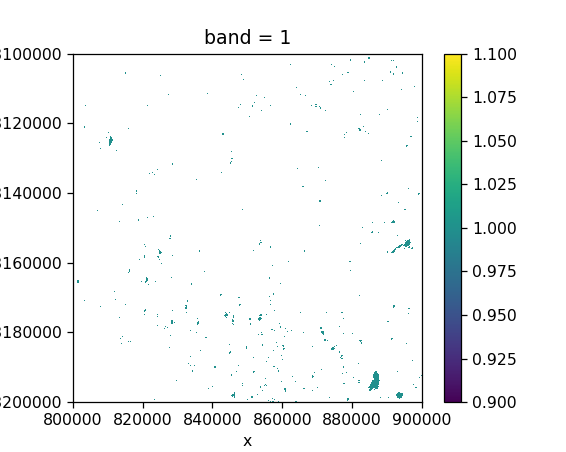

In [11]:
Estuaries = gp.read_file('/g/data/r78/cek156/ShapeFiles/OzCoastsCoastalWaterwaysGeomorphicHabitatMapping/Aus_geohab_av.shp')
Estuaries = Estuaries.to_crs({'init': 'epsg:3577'})
Estuaries.plot(figsize=(5, 4))

## Loop through each tile and polygonise the annual WOfS data

Within this cell, you need to set up:
- years to analyse: `for year in range(2000,2019)` - note that the last year is NOT included in the analysis
- WOFSInputFolder: Where are the datacube-stats netCDF files located?
- WOFSshp: The name and filepath of the intermediate output polygon set
- WOFSshpMerged: The name and filepath of the final corrected output polygon set
- AlbersBuffer: The file location of a shapefile that is a 1 pixel buffer around the Albers tile boundaries

In [12]:
### Set up some file names for the inputs and outputs

# Where are the datacube-stats netCDF files located?
TileFolder = '/g/data/r78/cek156/datacube_stats/WOFSDams2000to2018/'

# The name and filepath of the intermediate output polygon set
WOFSshp = f'/g/data/r78/cek156/dea-notebooks/Dams/Dams2000to2018/AllNSW2000to201810pcMinRiverLSTemp.shp'

# The name and filepath of the final corrected output polygon set
WOFSshpMerged = f'/g/data/r78/cek156/dea-notebooks/Dams/Dams2000to2018/AllNSW2000to201810pcMinRiverLSCleaned.shp'

In [24]:
# Does the analysis a year at a time. If there is a singple year only, set the year range to be 
# `range(year, year + 1)`

for year in range(2000,2001):
    
    ### Get the list of netcdf file names to loop through
    if CustomRegion == True:
        # Grab the file names from the custom folder we specified
        Alltiles = GenerateListofTileDatasets(ListofAlbersTiles, year, TileFolder)
    else:
        # Grab the all time summaries
        # Note that the location of these files must be set with the `TileFolder` parameter above
        Alltiles = glob.glob(f'{TileFolder}*_{year}_summary.nc')
        
    for WOFSfile in Alltiles: 
#         try:
        # Read in the data
        WOFSnetCDFData = xr.open_rasterio(f'NETCDF:{WOFSfile}:frequency')
        # Remove the superfluous time dimension
        WOFSnetCDFData = WOFSnetCDFData.squeeze()
        
        # Filter our WOfS classified data layer to remove noise
        # Remove any pixels that are wet < AtLeastThisWet% of the time
        WOFSfiltered = WOFSnetCDFData > AtLeastThisWet
        # Change all zeros to NaN to create a nan/1 mask layer
        # Pixels == 1 now represent our water bodies
        WOFSfiltered = WOFSfiltered.where(WOFSfiltered !=0)
        
        # Filter out any ocean in the pixel
        coastline_mask = rasterio.features.geometry_mask(coastline_gp.geometry,
                                                         out_shape = WOFSfiltered.shape,
                                                         transform = WOFSnetCDFData.transform)
        # Filter out the estuaries
        estuaries_mask = rasterio.features.geometry_mask(Estuaries.geometry,
                                                         out_shape = WOFSfiltered.shape,
                                                         transform = WOFSnetCDFData.transform)
        
        # Now apply the two masks
        # Note that the mask is 1 over ocean, so it needs to be inverted
        NotOcean = WOFSfiltered.where(~coastline_mask)
        NotEstuary = NotOcean.where(estuaries_mask)
        
        # Convert the raster to polygons
        # We use a mask of '1' to only generate polygons around values of '1' (not NaNs)
        WOFSpolygons = rasterio.features.shapes(NotEstuary.data.astype('float32'), 
                                                mask = NotEstuary.data.astype('float32') == 1,
                                                transform = WOFSnetCDFData.transform)
        # The rasterio.features.shapes returns a tuple. We only want to keep the geometry portion,
        # not the value of each polygon (which here is just 1 for everything)
        WOFSbreaktuple = (a for a, b in WOFSpolygons)
        
        # Put our polygons into a geopandas geodataframe
        PolygonGP = gp.GeoDataFrame(list(WOFSbreaktuple))
        
        # Grab the geometries and convert into a shapely geometry
        # so we can quickly calcuate the area of each polygon
        PolygonGP['geometry'] = None
        for ix, poly in PolygonGP.iterrows():
            poly['geometry'] = shape(poly)
            
        # Set the geometry of the dataframe to be the shapely geometry we just created    
        PolygonGP = PolygonGP.set_geometry('geometry')
        # We need to add the crs back onto the dataframe
        PolygonGP.crs = {'init': 'epsg:3577'}
        
        # Calculate the area of each polygon
        # Note that we are working in Albers Equal Area coordinates, so the answer
        # here is in m2
        PolygonGP['area'] = PolygonGP['geometry'].area
        
        # Filter out any polygons smaller than MinSize, and greater than MaxSize
        WaterBodiesBig = PolygonGP.loc[((PolygonGP['area'] > MinSize) & (PolygonGP['area'] <= MaxSize))]
        
        # Here is where we do the river filtering (if FilterOutRivers == True)
        if FilterOutRivers:
            WaterBodiesBigRiverFiltered = FilterRivers(WaterBodiesBig, MajorRivers)
        else:
            # If river filtering is turned off, then we just keep all the same polygons
            WaterBodiesBigRiverFiltered = WaterBodiesBig
           
        # Combine any overlapping polygons
        MergedPolygonsGeoms = unary_union(WaterBodiesBigRiverFiltered['geometry'])
        
        # Turn the combined multipolygon back into a geodataframe
        MergedPolygonsGPD = gp.GeoDataFrame([poly for poly in MergedPolygonsGeoms])
        # Rename the geometry column
        MergedPolygonsGPD.columns = ['geometry']
        # We need to add the crs back onto the dataframe
        MergedPolygonsGPD.crs = {'init': 'epsg:3577'}
        
        # Calculate the area of each polygon again now that overlapping polygons
        # have been merged
        MergedPolygonsGPD['area'] = MergedPolygonsGPD['geometry'].area
        
        # Save the polygons to a shapefile
        schema = {'geometry': 'Polygon','properties': {'area': 'str'}}

        if os.path.isfile('test.shp'):
            with fiona.open('test.shp', "a", crs = from_epsg(3577), driver = 'ESRI Shapefile', schema = schema) as output:
                for ix, poly in MergedPolygonsGPD.iterrows():
                                output.write(({'properties': {'area': poly['area']},'geometry': mapping(shape(poly['geometry']))})) 
        else:
            with fiona.open('test.shp', "w", crs = from_epsg(3577), driver = 'ESRI Shapefile', schema = schema) as output:
                for ix, poly in MergedPolygonsGPD.iterrows():
                    output.write(({'properties': {'area': poly['area']},'geometry': mapping(shape(poly['geometry']))}))


Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f86bab64940>>
Traceback (most recent call last):
  File "/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'


In [66]:
MergedPolygonsGPD.crs = {'init': 'epsg:3577'}

In [17]:
    ## Merge polygons that have an edge at a tile boundary

    #Now that we have all of the polygons across our whole region of interest, we need to check 
    #for artifacts in the data caused by tile boundaries. 

    # Load in a shapefile of the albers tile boundaries
    # We have created a shapefile that consists of the albers tile boundaries,
    # plus a 1 pixel (25 m) buffer. This shapefile will help us to find any polygons that have a
    # boundary at the edge of an albers tile. We can then find where polygons touch across this
    # boundary, and join them up.

    AlbersBuffer = gp.read_file(
        '/g/data/r78/cek156/ShapeFiles/AlbersBuffer25m.shp')

    DamPolygons = gp.read_file(WOFSshp)

    # Find where the albers polygon overlaps with our dam polygons
    # Perform a spatial join for polygons that intersect
    Intersects = gp.sjoin(AlbersBuffer, DamPolygons, how='inner', op='intersects')
    # Get the index of the dam polygons that intersect with the Albers buffer
    IntersectIndex = sorted(Intersects['index_right'])

    # Get just the dams that intersect with the tile boundaries
    BoundaryDams = DamPolygons.iloc[IntersectIndex]
    NotBoundaryDams = DamPolygons.loc[~DamPolygons.index.isin(IntersectIndex)]

    # Now combine overlapping polygons in `BoundaryDams`
    UnionBoundaryDams = BoundaryDams.unary_union

    # `Explode` the multipolygon back out into individual polygons
    UnionGDF = gp.GeoDataFrame(crs=DamPolygons.crs, geometry=[UnionBoundaryDams])
    MergedDams = UnionGDF.explode()

    # Then combine our new merged polygons with the `NotBoundaryDams`
    # Combine New merged polygons with the remaining polygons that are not near the tile boundary
    AllTogether = gp.GeoDataFrame(pd.concat([NotBoundaryDams, MergedDams],
                                            ignore_index=True, sort=True)).set_geometry('geometry')

    # Calculate the area of each polygon
    AllTogether['area'] = AllTogether.area

    # Then write the lot out to shapefile
    AllTogether.crs = {'init': 'epsg:3577'}
    AllTogether.to_file(WOFSshpMerged, driver='ESRI Shapefile')

(4000, 4000)

<IPython.core.display.Javascript object>


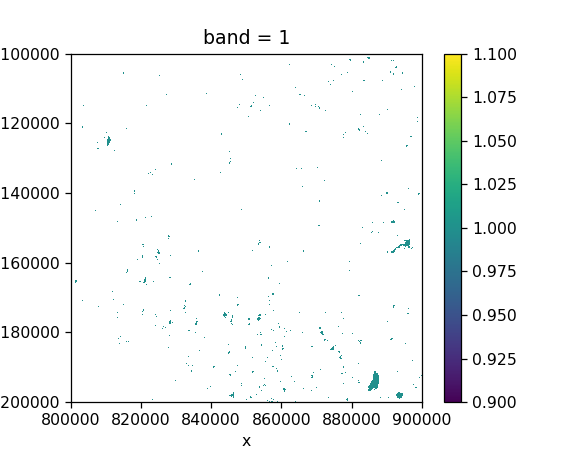

In [22]:
NotEstuary.plot(figsize=(5, 4))